In [1]:
#conda create -y  -n xcdat_jupter python=3.10
#conda install --prefix=/global/homes/z/zhan391/.conda/envs/xcdat_jupter -c conda-forge xarray netcdf4 nco xcdat xesmf matplotlib nc-time-axis ipython ipykernel cartopy numpy pyesmf esmpy pyproj
#under your HPC or local terminal window, execuate following command: 
#python -m ipykernel install --user --name xcdat_jupter --display-name xcdat_jupter
#After above step, you can launch the xcdat_jupter from jupter Launcher section, and then run the example script

In [49]:
from cartopy import crs, feature
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.crs as ccrs
import esmpy as ESMF
from matplotlib import cm, rcParams
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import xarray as xr
import pyproj
import os
import glob
import xcdat

In [50]:
#Open a dataset:
indir   = '/global/cfs/cdirs/e3sm/www/zhan391/darpa_temporary_data_share/SE_PG2/before_nudging'
infile  = os.path.join(indir,"E3SMv2_NDGUV_tau6_3hourly_201101010000-201112312100.nc")
#ds = xcdat.open_dataset(infile,decode_times=False)
# opend the data in read-only mode
dataset = xcdat.open_mfdataset(infile,decode_times=False)
time    = dataset.variables['time']
lat     = dataset.variables['lat'][:]
lon     = dataset.variables['lon'][:]
lev     = dataset.variables['lev'][:]

In [51]:
#Extract variable and data at specific time
#total varlist: ["U_bf_ndg","V_bf_ndg", "T_bf_ndg", "Q_bf_ndg", "PS_bf_ndg"]
varnam  = "U_bf_ndg" # variable kept 
itime   = 0
ilev    = 71
ds      = dataset.drop_vars(["V_bf_ndg", "T_bf_ndg", "Q_bf_ndg", "PS_bf_ndg"])
ds      = ds.isel(time=0)

In [52]:
workdir = '/pscratch/sd/z/zhan391/DARPA_project/post_process/share_python'
src_flg = os.path.join(workdir,"mesh","ne30pg2_grid.nc")
src_msh = ESMF.Mesh(filename=src_flg,filetype=ESMF.FileFormat.ESMFMESH)
srcfld  = ESMF.Field(src_msh,name="srcfield",staggerloc=ESMF.StaggerLoc.CENTER)
srcfld.data[:] = ds[varnam][ilev,:]

In [136]:
#print(src_msh)
#vplt = ds[varnam][:,:]
#vplt[:,:] = ds[varnam][ilev,:]
#print(vplt.shape)
#plt.contourf(vplt)
#plt.colorbar()

In [137]:
dst_flg = os.path.join(workdir,"mesh","cmip6_180x360_scrip.20181001.nc")
dst_msh = ESMF.Grid(filename=dst_flg,filetype=ESMF.FileFormat.SCRIP)
dstfld  = ESMF.Field(dst_msh,name="dstfield",staggerloc=ESMF.StaggerLoc.CENTER)
dstfld.data[:,:] = 1e20
#print(dst_msh)
#print(dstfld)

In [140]:
#use an existing mapping file provided by E3SM 
mapping = os.path.join(workdir,'mesh','map_ne30pg2_to_cmip6_180x360_aave.20200201.nc')
#mapping = os.path.join(workdir,'mesh','esmf_ne30pg2_to_cmip6_180x360_bliner.nc')
if os.path.isfile(mapping):
    #use an existing mapping file provided by E3SM
    print("mapping file: " + mapping)
else:
    #user can also customize a mapping file if no available mapping file:
    print("mapping file not exist, generate it:")
    mg = ESMF.Manager(debug=True)
    mg.barrier()
    regrid = ESMF.Regrid(srcfld,dstfld,filename=mapping,
                         regrid_method=ESMF.RegridMethod.BILINEAR,
                         unmapped_action=ESMF.UnmappedAction.IGNORE)

    print("mapping file not exist, quit")
    
#regrid 
regrid = ESMF.RegridFromFile(srcfld,dstfld,mapping)
dstfld = regrid(srcfld, dstfld)

#initialize xarry to save and plot data
rgdfld = dstfld.data[:][:]
rgdfld = np.transpose(rgdfld)
lon2d  = dstfld.grid.coords[0][0]
lat2d  = dstfld.grid.coords[0][1]
lon    = lon2d[:,0]
lat    = lat2d[0,:]
print(lon.shape,lat.shape)
da = xr.Dataset(
    data_vars=dict(
        nudge_var=(["lat", "lon"],rgdfld),
    ),
    coords=dict(
        Latitude=("lat", lat),
        Longitude=("lon", lon),
    ),
    attrs=dict(description="ML related data."),
)

#output the data to a netcdf file
outfile  = os.path.join(workdir,'{}_{:02d}_{:02d}_rgd_180x360.nc'.format(varnam,itime,ilev))
da.to_netcdf(outfile)

mapping file: /pscratch/sd/z/zhan391/DARPA_project/post_process/share_python/mesh/map_ne30pg2_to_cmip6_180x360_aave.20200201.nc
(360,) (180,)


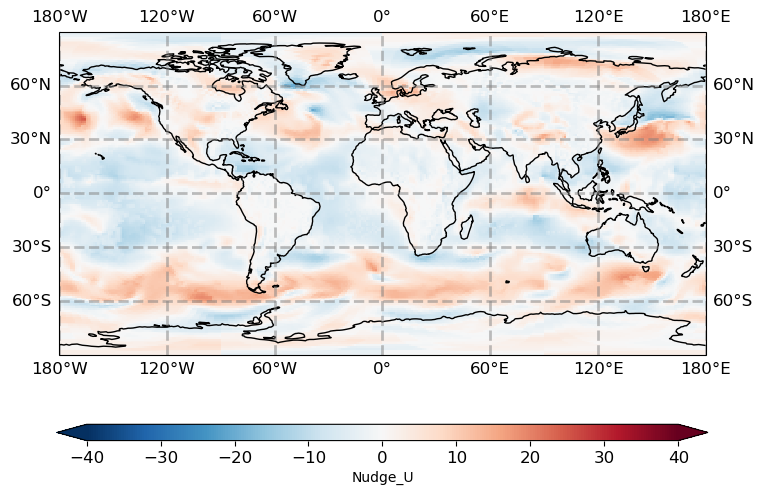

In [141]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np

#plot the figure
# This is the map projection we want to plot *onto*
#map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
#map_proj = ccrs.LambertCylindrical(central_longitude=0.0, globe=None)
#map_proj = ccrs.Robinson(central_longitude=0, globe=None, false_easting=None, false_northing=None)
map_proj = ccrs.PlateCarree(central_longitude=0.0, globe=None)
#print(da['nudge_var'].dims["lon"])
plt.figure(figsize=[12,6])

subplot_kws = dict(projection=map_proj,facecolor='grey')
#fig, axis = plt.subplots(1, 1, figsize=(12,6), subplot_kw=dict(projection=map_proj))
p = da['nudge_var'].plot(
    x='Longitude', y='Latitude', #ax=axis, 
    vmin=-40, vmax=40, extend="both", 
    cmap = "RdBu_r", #cmocean.cm.thermal,
    subplot_kws=subplot_kws,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    add_labels=False,
    # usual xarray stuff
    #cbar_kwargs={"orientation": "horizontal", "shrink": 0.7},
    robust=True,
)

fontsize=12
# add separate colorbar
cb = plt.colorbar(p, label = "Nudge_U", ticks=[-40,-30,-20,-10,0,10,20,30,40], orientation="horizontal", shrink=0.7, aspect=40, extend="both")
cb.ax.tick_params(labelsize=fontsize)

#add coastlines 
p.axes.coastlines()  # cartopy function

# draw parallels/meridiens and write labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

# adjust labels to taste
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fontsize, 'color': 'black'}
gl.ylabel_style = {'size': fontsize, 'color': 'black'}